In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set device and random seed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# === Define GRBM model with L matrix ===
class GRBM(nn.Module):
    def __init__(self, n_vis, n_target, n_hid, k=1):
        super(GRBM, self).__init__()
        self.n_vis = n_vis
        self.n_target = n_target
        self.n_hid = n_hid
        self.k = k

        # Parameters
        self.W = nn.Parameter(torch.randn(n_vis, n_hid) * 0.01)
        self.U = nn.Parameter(torch.randn(n_target, n_hid) * 0.01)
        self.L = nn.Parameter(torch.randn(n_hid, n_hid) * 0.01)
        self.b = nn.Parameter(torch.zeros(n_vis))
        self.c = nn.Parameter(torch.zeros(n_hid))
        self.d = nn.Parameter(torch.zeros(n_target))
        
        # Initialize lateral connection state
        self.register_buffer('sample_h_prev', None)

    def reset_lateral(self, batch_size):
        """Reset lateral connections for a new batch"""
        self.sample_h_prev = torch.zeros(batch_size, self.n_hid, device=self.W.device)

    def sample_h(self, v, y):
        # Handle lateral connections
        if self.sample_h_prev is None or self.sample_h_prev.size(0) != v.size(0):
            self.reset_lateral(v.size(0))
        
        lateral_term = torch.matmul(self.sample_h_prev, self.L.T)
        pre_activation = torch.matmul(v, self.W) + torch.matmul(y, self.U) + lateral_term + self.c
        prob_h = torch.sigmoid(pre_activation)
        self.sample_h_prev = prob_h.detach()  # Store for next step
        return prob_h, torch.bernoulli(prob_h)

    # ... (keep other methods the same)


    def sample_v(self, h):
        pre_activation = torch.matmul(h, self.W.t()) + self.b
        # Gaussian visible units: mean = pre_activation
        return pre_activation, pre_activation

    def sample_y(self, h):
        logits = torch.matmul(h, self.U.t()) + self.d
        prob_y = torch.softmax(logits, dim=1)
        return prob_y, torch.bernoulli(prob_y)

    def free_energy(self, v, y):
        vbias_term = torch.sum((v - self.b) ** 2, dim=1) / 2
        hidden_term = torch.sum(
            F.softplus(torch.matmul(v, self.W) + torch.matmul(y, self.U) + self.c), dim=1
        )
        ybias_term = torch.sum(y * self.d, dim=1)
        return vbias_term - hidden_term - ybias_term

    def gibb(self, v0, y0):
        v, y = v0, y0
        self.sample_h_prev = torch.zeros(v.size(0), self.n_hid, device=v.device)  # reset lateral hidden states
        for _ in range(self.k):
            _, h = self.sample_h(v, y)
            _, v = self.sample_v(h)
            _, y = self.sample_y(h)
        return v0, v, y0, y

    def forward(self, v):
        batch_size = v.size(0)
        probs = []

        for label in range(self.n_target):
            y = torch.zeros(batch_size, self.n_target, device=v.device)
            y[:, label] = 1.0
            fe = self.free_energy(v, y)
            probs.append(-fe)

        probs = torch.stack(probs, dim=1)
        return torch.softmax(probs, dim=1)

# === Load Data ===
def load_data():
    X_train = pd.read_csv('Train.csv').values.astype(np.float32)
    y_train = pd.read_csv('TrainLabel.csv').values.squeeze().astype(np.int64)
    X_test = pd.read_csv('Test.csv').values.astype(np.float32)
    y_test = pd.read_csv('TestLabel.csv').values.squeeze().astype(np.int64)
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)  # Fit on train only
    # X_test = scaler.transform(X_test)       # Transform test
    return X_train, y_train, X_test, y_test

# === Train Model ===
def train(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # One-hot encode targets
            target_onehot = torch.zeros(len(target), model.n_target, device=device)
            target_onehot.scatter_(1, target.unsqueeze(1), 1)

            optimizer.zero_grad()
            v_pos, v_neg, y_pos, y_neg = model.gibb(data, target_onehot)

            loss = model.free_energy(v_pos, y_pos) - model.free_energy(v_neg, y_neg)
            loss = loss.mean()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

# === Evaluate Model ===
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, device=device)
        outputs = model(X_test_tensor)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    print("\nTest Results:")
    print(" Accuracy:", accuracy_score(y_test, preds))
    # print("\n Confusion Matrix:\n", confusion_matrix(y_test, preds))
    # print(" Classification Report:\n",
    #       classification_report(y_test, preds, target_names=["Control", "Alzheimer"]))

# === Find Top Hub Genes ===
def find_top_hub_genes(model, gene_names=None, top_k=10):
    with torch.no_grad():
        W = model.W.cpu().numpy()  # (n_vis, n_hid)
        L = model.L.cpu().numpy()  # (n_hid, n_hid)

        # Gene-gene influence matrix: W * L * W^T
        influence_matrix = W @ L @ W.T  # (n_vis, n_vis)

        # Centrality scores: sum of absolute influences per gene
        scores = np.sum(np.abs(influence_matrix), axis=1)

        top_indices = np.argsort(scores)[-top_k:][::-1]

        if gene_names is None:
            gene_names = [f"Gene_{i}" for i in range(len(scores))]

        top_genes = [(gene_names[i], scores[i]) for i in top_indices]
        return top_genes

# === Main Execution ===
if __name__ == "__main__":
    # Load data
    X_train, y_train, X_test, y_test = load_data()

    # Create DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize model
    n_vis = X_train.shape[1]
    n_target = 2
    n_hid = 128
    model = GRBM(n_vis=n_vis, n_target=n_target, n_hid=n_hid, k=1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    train(model, train_loader, optimizer, epochs=25)

    # Evaluate
    evaluate(model, X_test, y_test)

    # Load gene names from CSV if available
    try:
        gene_names = pd.read_csv('Train.csv').columns.tolist()
    except Exception:
        gene_names = None

    # Find and print top 10 hub genes
    top_genes = find_top_hub_genes(model, gene_names=gene_names, top_k=10)
    print("\n Top 10 Hub Genes:")
    for gene, score in top_genes:
        print(f"{gene}: {score:.4f}")


Epoch 1/25, Loss: 6004.3398
Epoch 2/25, Loss: 5864.2256
Epoch 3/25, Loss: 5690.7603
Epoch 4/25, Loss: 5513.2734
Epoch 5/25, Loss: 5350.8784
Epoch 6/25, Loss: 5204.4199
Epoch 7/25, Loss: 5070.7158
Epoch 8/25, Loss: 4948.5957
Epoch 9/25, Loss: 4840.4111
Epoch 10/25, Loss: 4736.8896
Epoch 11/25, Loss: 4643.1519
Epoch 12/25, Loss: 4555.5947
Epoch 13/25, Loss: 4474.8257
Epoch 14/25, Loss: 4397.7109
Epoch 15/25, Loss: 4323.7095
Epoch 16/25, Loss: 4258.0166
Epoch 17/25, Loss: 4196.9639
Epoch 18/25, Loss: 4140.2412
Epoch 19/25, Loss: 4084.8555
Epoch 20/25, Loss: 4033.8430
Epoch 21/25, Loss: 3984.0952
Epoch 22/25, Loss: 3935.6074
Epoch 23/25, Loss: 3890.5000
Epoch 24/25, Loss: 3847.5989
Epoch 25/25, Loss: 3805.5918

Test Results:
 Accuracy: 0.8695652173913043

 Top 10 Hub Genes:
X51761: 11.7115
X9442: 11.3490
X3679: 11.2042
X335: 10.4444
X8578: 10.3015
X11117: 10.2779
X671: 10.2706
X9650: 10.2124
X23341: 10.1509
X1774: 10.1130


Visualizing model architecture...


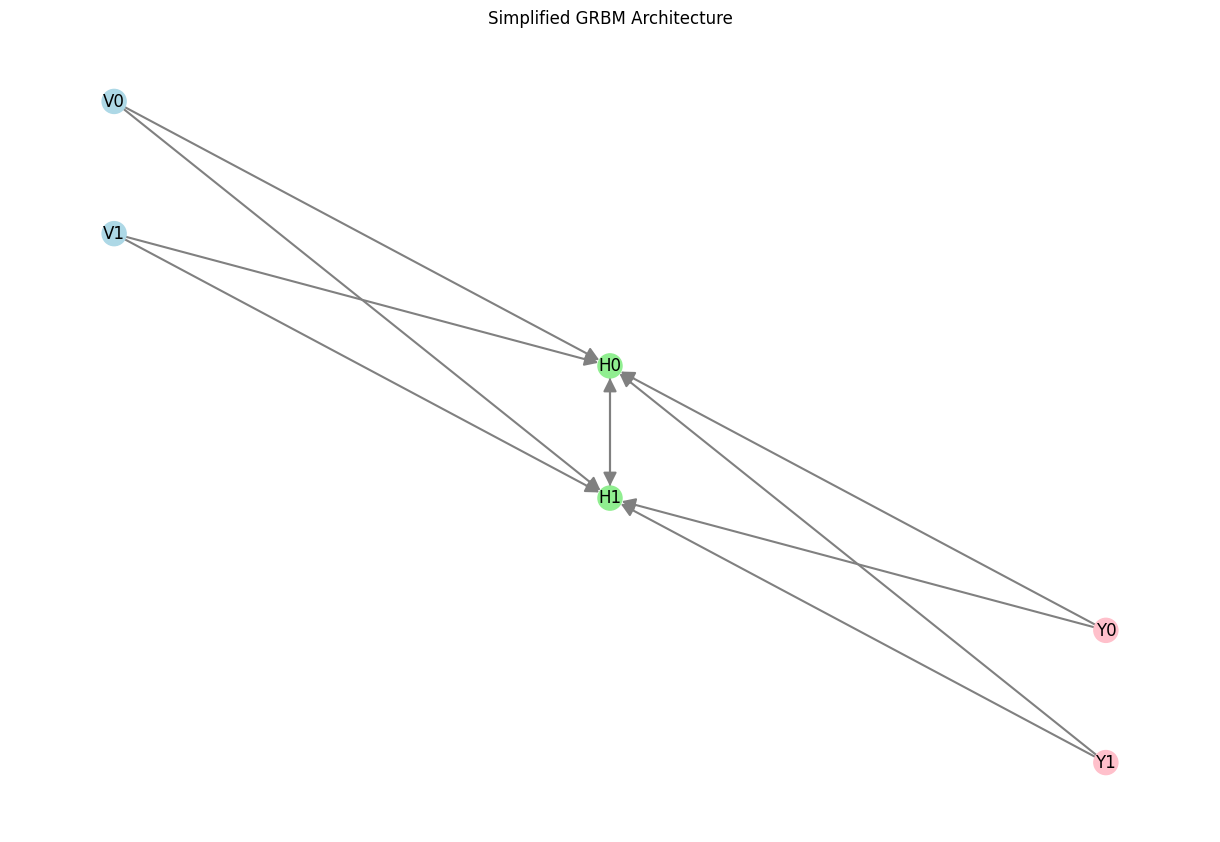


Visualizing weight matrices...


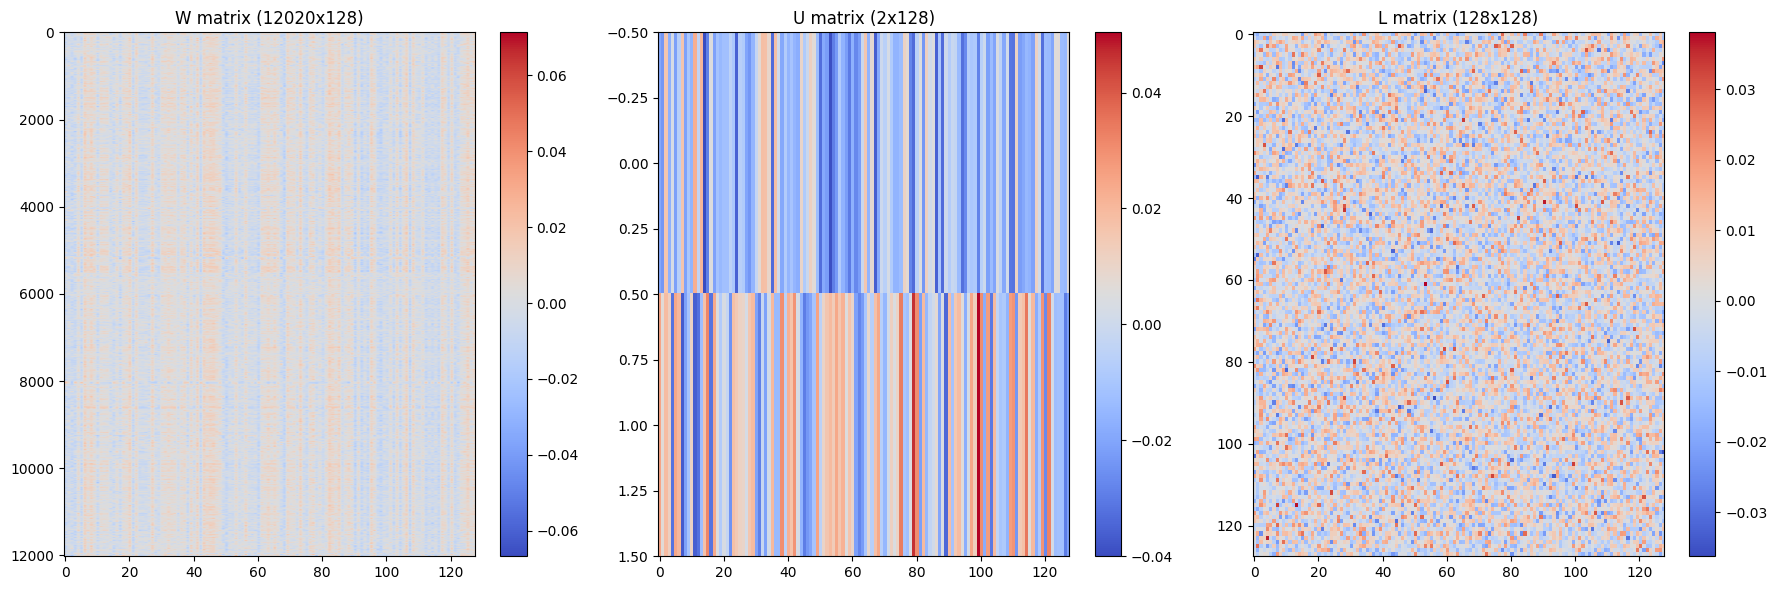


Visualizing hidden activations...


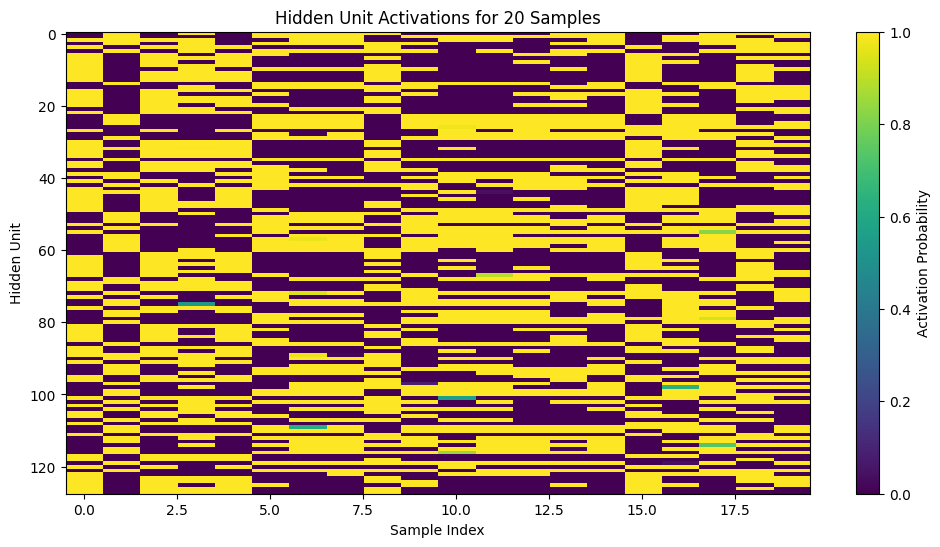


Visualizing hub genes...


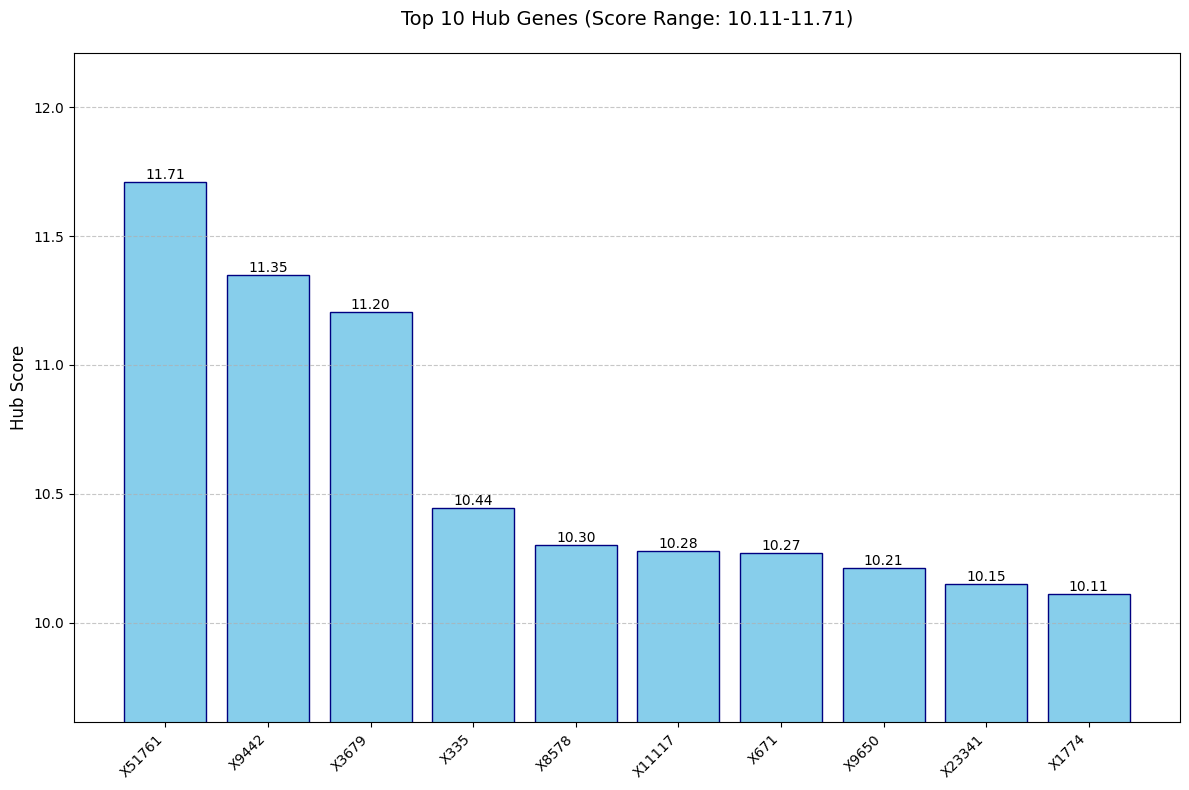

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

def visualize_model_architecture(model):
    plt.figure(figsize=(12, 8))
    
    # Create a simplified graph (showing just a few units for clarity)
    G = nx.DiGraph()
    
    # Add a subset of nodes
    n_to_show = min(5, model.n_vis, model.n_hid, model.n_target)
    G.add_nodes_from([f"V{i}" for i in range(n_to_show)], layer=0, color='lightblue')
    G.add_nodes_from([f"H{i}" for i in range(n_to_show)], layer=1, color='lightgreen')
    G.add_nodes_from([f"Y{i}" for i in range(n_to_show)], layer=2, color='pink')
    
    # Add edges (only between the subset)
    for i in range(n_to_show):
        for j in range(n_to_show):
            if i < model.n_vis and j < model.n_hid:
                G.add_edge(f"V{i}", f"H{j}", weight=model.W[i,j].item())
            if i < model.n_target and j < model.n_hid:
                G.add_edge(f"Y{i}", f"H{j}", weight=model.U[i,j].item())
            if i < model.n_hid and j < model.n_hid and i != j:
                G.add_edge(f"H{i}", f"H{j}", weight=model.L[i,j].item(), style='dashed')
    
    # Position nodes
    pos = {}
    for i, node in enumerate(G.nodes()):
        if node.startswith('V'):
            pos[node] = (0, -i)
        elif node.startswith('H'):
            pos[node] = (1, -i)
        else:
            pos[node] = (2, -i)
    
    # Draw
    colors = [G.nodes[node]['color'] for node in G]
    nx.draw(G, pos, with_labels=True, node_color=colors, 
            edge_color='gray', width=1.5, arrowsize=20)
    plt.title("Simplified GRBM Architecture")
    plt.show()

def visualize_weight_matrices(model):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # W matrix
    W_np = model.W.detach().cpu().numpy()
    im = axes[0].imshow(W_np, cmap='coolwarm', aspect='auto')
    axes[0].set_title(f"W matrix ({W_np.shape[0]}x{W_np.shape[1]})")
    fig.colorbar(im, ax=axes[0])
    
    # U matrix
    U_np = model.U.detach().cpu().numpy()
    im = axes[1].imshow(U_np, cmap='coolwarm', aspect='auto')
    axes[1].set_title(f"U matrix ({U_np.shape[0]}x{U_np.shape[1]})")
    fig.colorbar(im, ax=axes[1])
    
    # L matrix
    L_np = model.L.detach().cpu().numpy()
    im = axes[2].imshow(L_np, cmap='coolwarm', aspect='auto')
    axes[2].set_title(f"L matrix ({L_np.shape[0]}x{L_np.shape[1]})")
    fig.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

def visualize_hidden_activations(model, X_sample):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_sample, dtype=torch.float32, device=device)
        y_tensor = torch.zeros(X_tensor.size(0), model.n_target, device=device)
        
        # Reset lateral connections
        if hasattr(model, 'sample_h_prev'):
            model.sample_h_prev = None
            
        probs, _ = model.sample_h(X_tensor, y_tensor)
        activations = probs.cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.imshow(activations.T, cmap='viridis', aspect='auto')
    plt.colorbar(label='Activation Probability')
    plt.xlabel('Sample Index')
    plt.ylabel('Hidden Unit')
    plt.title(f'Hidden Unit Activations for {len(X_sample)} Samples')
    plt.show()

def visualize_hub_genes(model, gene_names=None, top_k=10):
    with torch.no_grad():
        W = model.W.cpu().numpy()
        L = model.L.cpu().numpy()
        influence_matrix = W @ L @ W.T
    
    scores = np.sum(np.abs(influence_matrix), axis=1)
    top_indices = np.argsort(scores)[-top_k:][::-1]
    top_scores = scores[top_indices]
    
    # Create figure with adjusted layout
    plt.figure(figsize=(12, 8))
    
    # Plot with adjusted y-axis
    bars = plt.bar(range(top_k), top_scores, color='skyblue', edgecolor='navy')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=10)
    
    # Customize y-axis to focus on the relevant range
    score_min, score_max = min(top_scores), max(top_scores)
    plt.ylim(score_min - 0.5, score_max + 0.5)  # Add some padding
    
    # X-axis labels
    if gene_names is not None:
        plt.xticks(range(top_k), [gene_names[i] for i in top_indices], 
                  rotation=45, ha='right', fontsize=10)
    else:
        plt.xticks(range(top_k), [f"Gene {i}" for i in top_indices], 
                  rotation=45, fontsize=10)
    
    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.ylabel('Hub Score', fontsize=12)
    plt.title(f'Top {top_k} Hub Genes (Score Range: {score_min:.2f}-{score_max:.2f})', 
             fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

def visualize_class_separation(model, X, y, n_samples=500):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X[:n_samples], dtype=torch.float32, device=device)
        y_tensor = torch.zeros(X_tensor.size(0), model.n_target, device=device)
        
        # Reset lateral connections
        if hasattr(model, 'sample_h_prev'):
            model.sample_h_prev = None
            
        probs, _ = model.sample_h(X_tensor, y_tensor)
        hidden_repr = probs.cpu().numpy()
    
    # Use t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    hidden_2d = tsne.fit_transform(hidden_repr)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(hidden_2d[:, 0], hidden_2d[:, 1], c=y[:n_samples], 
                         cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class')
    plt.title('Hidden Space Representation (t-SNE)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Run visualizations
print("Visualizing model architecture...")
visualize_model_architecture(model)

print("\nVisualizing weight matrices...")
visualize_weight_matrices(model)

print("\nVisualizing hidden activations...")
visualize_hidden_activations(model, X_train[:50])  # Use first 50 samples

print("\nVisualizing hub genes...")
visualize_hub_genes(model, gene_names)

# print("\nVisualizing class separation...")
# visualize_class_separation(model, X_test, y_test)